In [6]:
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm

# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
# For convenience, we assume all rewards are 0
# and the left terminal state has value 0, the right terminal state has value 1
# This trick has been used in Gambler's Problem
VALUES[6] = 1

# set up true state values
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def temporal_difference(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]
    rewards = [0]
    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        # Assume all rewards are 0
        reward = 0
        trajectory.append(state)
        rewards.append(reward)
        # TD update
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state == 6 or state == 0:
            break
    return trajectory, rewards

# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def monte_carlo(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]

    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    while True:
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break

    if not batch:
        for state_ in trajectory[:-1]:
            # MC update
            values[state_] += alpha * (returns - values[state_])
    return trajectory, [returns] * (len(trajectory) - 1)

# Example 6.2 left
def compute_state_value():
    episodes = [0, 1, 10, 100]
    current_values = np.copy(VALUES)
    plt.figure(1)
    for i in range(episodes[-1] + 1):
        if i in episodes:
            plt.plot(("A", "B", "C", "D", "E"), current_values[1:6], label=str(i) + ' episodes')
        temporal_difference(current_values)
    plt.plot(("A", "B", "C", "D", "E"), TRUE_VALUE[1:6], label='true values')
    plt.xlabel('State')
    plt.ylabel('Estimated Value')
    plt.legend()

# Example 6.2 right
def rms_error():
    # Same alpha value can appear in both arrays
    td_alphas = [0.15, 0.1, 0.05]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    episodes = 100 + 1
    runs = 100
    for i, alpha in enumerate(td_alphas + mc_alphas):
        total_errors = np.zeros(episodes)
        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'
        for r in tqdm(range(runs)):
            errors = []
            current_values = np.copy(VALUES)
            for i in range(0, episodes):
                errors.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))
                if method == 'TD':
                    temporal_difference(current_values, alpha=alpha)
                else:
                    monte_carlo(current_values, alpha=alpha)
            total_errors += np.asarray(errors)
        total_errors /= runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', $\\alpha$ = %.02f' % (alpha))
    plt.xlabel('Walks/Episodes')
    plt.ylabel('Empirical RMS error, averaged over states')
    plt.legend()

# Figure 6.2
# @method: 'TD' or 'MC'
def batch_updating(method, episodes, alpha=0.001):
    # perform 100 independent runs
    runs = 100
    total_errors = np.zeros(episodes)
    for r in tqdm(range(0, runs)):
        current_values = np.copy(VALUES)
        current_values[1:6] = -1
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for ep in range(episodes):
            if method == 'TD':
                trajectory_, rewards_ = temporal_difference(current_values, batch=True)
            else:
                trajectory_, rewards_ = monte_carlo(current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)
            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'TD':
                            updates[trajectory_[i]] += rewards_[i+1] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
                        else:
                            updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
        total_errors += np.asarray(errors)
    total_errors /= runs
    return total_errors

def example_6_2():
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    compute_state_value()

    plt.subplot(2, 1, 2)
    rms_error()
    plt.tight_layout()

#     plt.savefig('../images/example_6_2.png')
#     plt.close()
    plt.show()

def figure_6_2():
    episodes = 100 + 1
    td_errors = batch_updating('TD', episodes)
    mc_errors = batch_updating('MC', episodes)

    plt.plot(td_errors, label='TD')
    plt.plot(mc_errors, label='MC')
    plt.title("Batch Training")
    plt.xlabel('Walks/Episodes')
    plt.ylabel('RMS error, averaged over states')
    plt.xlim(0, 100)
    plt.ylim(0, 0.25)
    plt.legend()

#     plt.savefig('../images/figure_6_2.png')
#     plt.close()
    plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 186.10it/s]


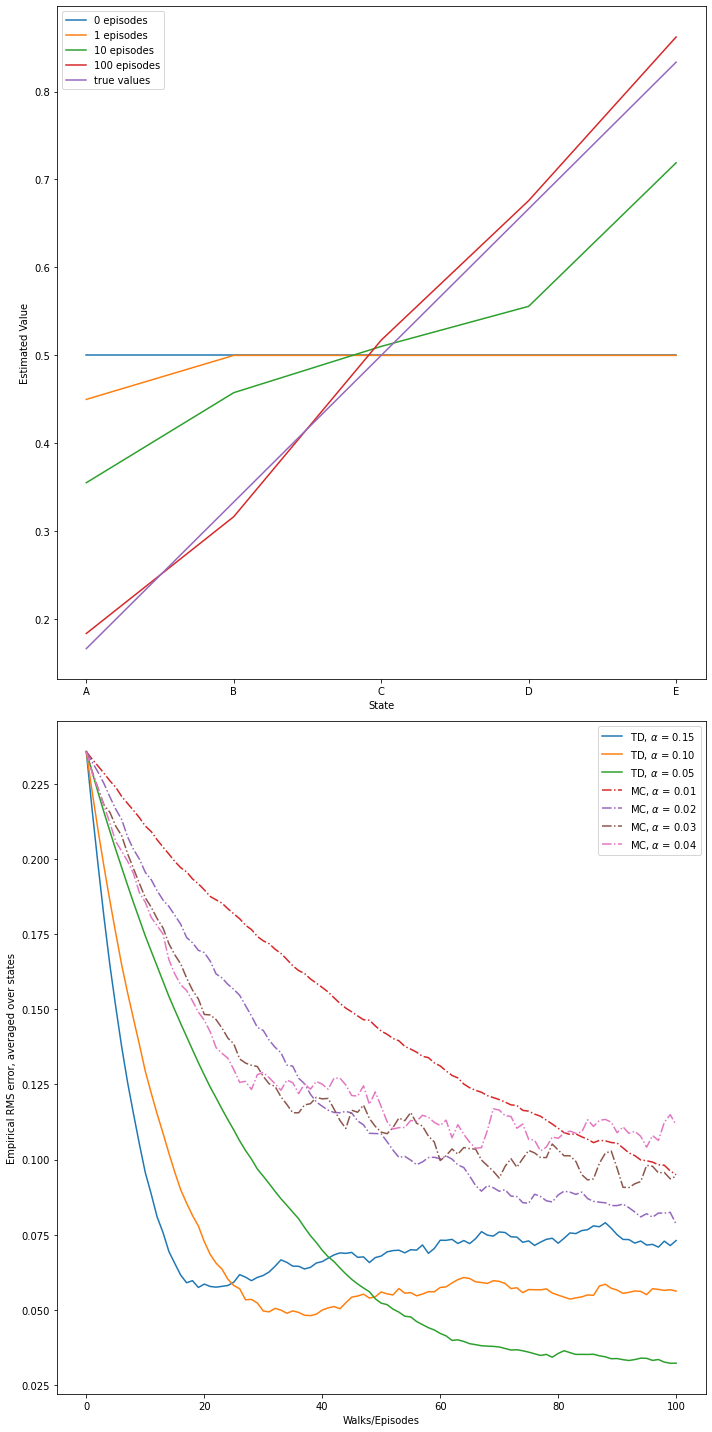

In [7]:
example_6_2()

In [ ]:
figure_6_2()

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 57/100 [00:37<00:24,  1.74it/s]